# Resultados SVM

# Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
from funcoes_module import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value
from funcoes_module import extract_info_from_filename, extract_and_format_dataframe, format_time, features_extract, features_timeframe,format_dataframe_basona ,extract_datasets_and_process_features,read_1file_datasets , combine_features_datasets 
from funcoes_module import plot_df,plot_df_features, compare_df_plots #,plot_health_non_health_features
from descricoes_SE import descricao_falha

In [3]:
redundant_ft_drop_list = ['gearbox_vibration_x.rms','gearbox_vibration_z.kurtosis','gearbox_vibration_z.rms','gearbox_vibration_x.crest_factor','gearbox_vibration_x.min','gearbox_vibration_x.pk_pk','Input Torque.mean']

## Funções Formatação

In [4]:
#### #### Funções Formatação #### ####
def normalize_data(dataframe):
    scaler = MinMaxScaler() 
    # Selecting numerical columns in the DataFrame
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #normalized_df =dataframe.copy()
    # Fitting the scaler and transforming the data
    df2 = dataframe.copy()
    df2[numerical_cols] = scaler.fit_transform(df2[numerical_cols])
    return df2

def fault_to_binary(dataframe):
    df_features = dataframe.copy()
    if not ((df_features['Fault'] == 0) | (df_features['Fault'] == 1)).all(): #condição para não dar ruim se aplicar 2x a função
        df_features['Fault'] = df_features['Fault'].apply(lambda x: 0 if x == 'health' else 1)
    #df_features['Fault'].value_counts()
    return df_features

def top_features_list(df_features, num_features):
    # Select numeric types from the DataFrame
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault'])
    
    # Drop the 'Fault' column from the series to avoid self-correlation
    top_features = top_features.drop('Fault', axis=0)
    
    # Get the 'num_features' largest values
    largest_features = top_features.nlargest(num_features)
    
    # Return the index of the largest features as a list
    features_chosen = largest_features.index.tolist()
    return features_chosen

def filter_top_features_df(df_features,top_features):    
    filtered_columns = top_features + ['Fault','Torque']#,'Degree']
    df_features = df_features[filtered_columns]
    return df_features

def format_dataframe_features(df_features_org,number_of_features):

    normalized_dataframe = normalize_data(df_features_org)
    binary_fault_dataframe = fault_to_binary(normalized_dataframe)

    top_ft_list = top_features_list(binary_fault_dataframe,number_of_features)

    df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
    return df_top_features,binary_fault_dataframe

# Início
- df_treino_ciclo1
- df_treino_ciclo2
- df_teste_ciclo1
- df_teste_ciclo2
  
Importando dataset treino

In [5]:
# importando e criando basone treino
df_features_org = combine_features_datasets("todos","inicial",0.1)
########df_features_org = df_features_org[df_features_org['Torque']=='20Nm']

#df_features_org2 = df_features_org.drop(columns=redundant_ft_drop_list) #dropando features redundantes
normalized_dataframe = normalize_data(df_features_org)

df_treino_ciclo2 = normalized_dataframe
df_treino_ciclo1 = fault_to_binary(normalized_dataframe) #transformando variável alvo em binário (encoding)


# Importando e criando basona teste
df_features_org_t = combine_features_datasets("todos","final",0.1) #treino,teste,todos ; inicial,final ; timeframe
#######df_features_org_t = df_features_org_t[df_features_org_t['Torque']=='20Nm']
#df_features_org_t2 = df_features_org_t.drop(columns=redundant_ft_drop_list)
normalized_dataframe_t = normalize_data(df_features_org_t)

df_teste_ciclo1 = fault_to_binary(normalized_dataframe_t)
df_teste_ciclo2 = normalized_dataframe_t


Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

# Organizando as variáveis 
## Organizando as variáveisCiclo1 
### Dividir Conjunto em treino e teste
- df_treino_ciclo1
- df_teste_ciclo1
  
importante usar o meu encoder próprio pq ele classifica do jeito q eu quero 1 = tudo menos health, 0 = health

Separando entre treino e teste

In [6]:
categorias_list = ['Categoria','Degree','Rotação']

dataset_treino_c1 = df_treino_ciclo1.drop(columns=categorias_list)   # 60%
dataset_teste_c1 = df_teste_ciclo1.drop(columns=categorias_list) #40%

Separando X e y

In [7]:
#treino
X_train_c1 = dataset_treino_c1.drop(columns='Fault')#.iloc[:,-2:] filtrar n features
y_train_c1 = dataset_treino_c1.pop('Fault')

#teste
X_test_c1 = dataset_teste_c1.drop(columns='Fault')
y_test_c1 = dataset_teste_c1.pop('Fault')


In [8]:
print(f' Treino: x ={X_train_c1.shape} ; y = {y_train_c1.shape}')
print(f' Teste: x ={X_test_c1.shape} ; y = {y_test_c1.shape}')

 Treino: x =(2160, 41) ; y = (2160,)
 Teste: x =(2133, 41) ; y = (2133,)


Tratando a coluna categórica 'Torque' com label encoding

In [9]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'Torque' column is in both X_train, X_val, and X_test
le = LabelEncoder()

# Fit and transform on the training data
X_train_c1['Torque'] = le.fit_transform(X_train_c1['Torque'])
X_test_c1['Torque'] = le.transform(X_test_c1['Torque'])

### Criando variáveis de treino e teste

In [10]:
categorias_list = ['Categoria','Degree','Rotação']

dataset_treino_c2 = df_treino_ciclo2.drop(columns=categorias_list)   # 60%
dataset_teste_c2 = df_teste_ciclo2.drop(columns=categorias_list) #40%

In [11]:
#treino
X_train_c2 = dataset_treino_c2.drop(columns='Fault')#.iloc[:,-2:] filtrar n features
y_train_c2x = dataset_treino_c2.pop('Fault')

#teste
X_test_c2 = dataset_teste_c2.drop(columns='Fault')
y_test_c2x = dataset_teste_c2.pop('Fault')

In [12]:
print(f' Treino: x ={X_train_c2.shape} ; y = {y_train_c2x.shape}')
print(f' Teste: x ={X_test_c2.shape} ; y = {y_test_c2x.shape}')

 Treino: x =(2160, 41) ; y = (2160,)
 Teste: x =(2133, 41) ; y = (2133,)


Label Encoders
- torque
- target (y)

In [13]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'Torque' column is in both X_train, X_val, and X_test
le = LabelEncoder()

# Fit and transform on the training data
X_train_c2['Torque'] = le.fit_transform(X_train_c2['Torque'])
X_test_c2['Torque'] = le.transform(X_test_c2['Torque'])

aplicando encoder na target variable (opcional aparentemente)

In [14]:

# # Initialize label encoder for target variable
le_y = LabelEncoder()

# # Fit and transform the target variable
y_train_c2 = le_y.fit_transform(y_train_c2x.values)
y_test_c2 = le_y.transform(y_test_c2x.values)

### Resultado:
Criação das variáveis:
- X_train_c1
- X_train_c2
- y_train_c1
- y_train_c2
-
- X_teste_c1
- X_teste_c2
- y_teste_c1
- y_teste_c2

# Execução dos modelos 

In [15]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Testando númerode features

# SVM


## Ciclo 2

Avaliando número de features

n= 1 score: 0.4032679738562091
n= 2 score: 0.40094091816295857
n= 3 score: 0.6380908046403355
n= 4 score: 0.7047227575767998
n= 5 score: 0.6999287222664591
n= 6 score: 0.865519890223723
n= 7 score: 0.8567738568580027
n= 8 score: 0.8569943462727972
n= 9 score: 0.8729161285202722
n= 10 score: 0.8704051079752984
n= 11 score: 0.8819982016738726
n= 12 score: 0.8846596432503975
n= 13 score: 0.8686061634747353
n= 14 score: 0.9077447338207768
n= 15 score: 0.8925549688074416
n= 16 score: 0.888459078948368
n= 17 score: 0.8998868027578207
n= 18 score: 0.9252283750382845
n= 19 score: 0.9144871593028993
n= 20 score: 0.9149871224218239
n= 21 score: 0.9259679950186452
n= 22 score: 0.9060159202353697
n= 23 score: 0.9050640086419063
n= 24 score: 0.9289886805799288
n= 25 score: 0.9263956674931263
n= 26 score: 0.9185565946157848
n= 27 score: 0.9199784136162732
n= 28 score: 0.9352865364222384
n= 29 score: 0.9440909095476733
n= 30 score: 0.938269464421333
n= 31 score: 0.9414551327001371
n= 32 score: 0.9327

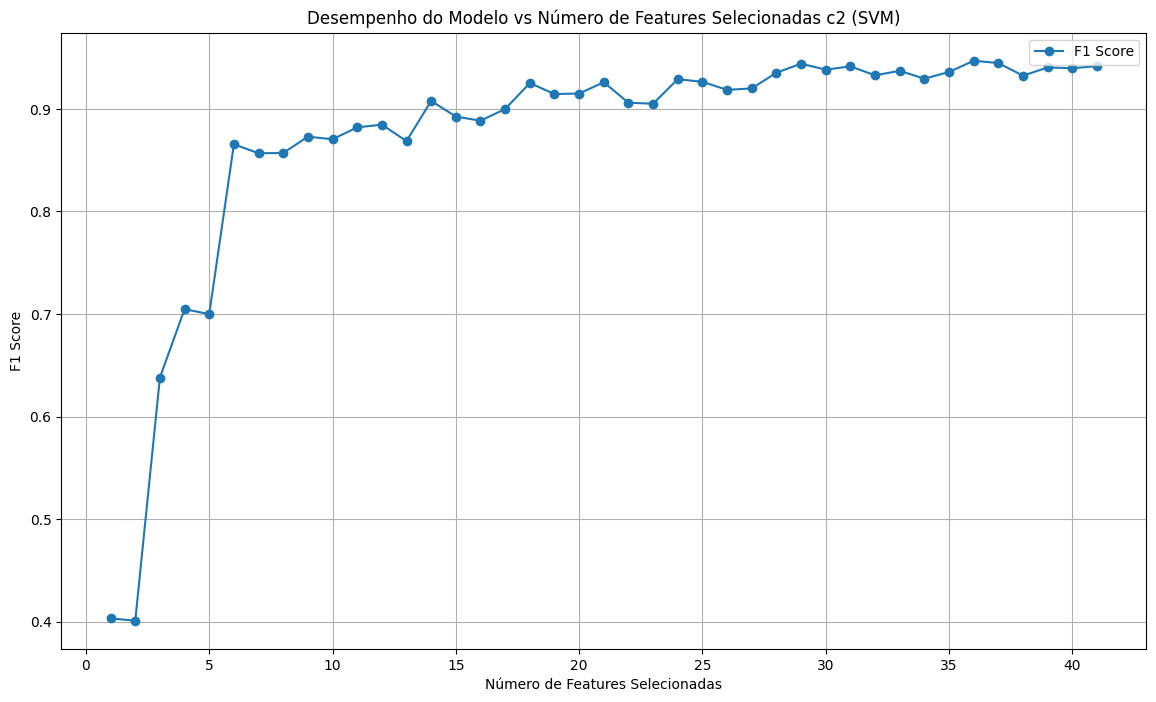

In [16]:
estimator = DecisionTreeClassifier()

# Listas para armazenar as métricas
num_features = list(range(1, X_train_c2.shape[1] + 1))
f1_scores = []
# Loop através de diferentes números de features
start_time_c2_ft = time.time()

for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train_c2, y_train_c2)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c2_rfe = rfe.transform(X_train_c2)
    X_test_c2_rfe = rfe.transform(X_test_c2)
    
    # Inicializar e treinar o modelo SVM
    svm_model = SVC()
    svm_model.fit(X_train_c2_rfe, y_train_c2)    
    # Fazer previsões no conjunto de teste
    y_pred_svm_test_c2 = svm_model.predict(X_test_c2_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')
    
    # Armazenar a métrica
    f1_scores.append(f1)
    print(f'n= {n} score: {f1}')

end_time_c2_ft = time.time()
# Plotar o F1 score em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1 Score')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas c2 (SVM)')
plt.legend()
plt.grid(True)
plt.show()

executar algoritmo com melhor feature (24)
e plotar matriz de confusão

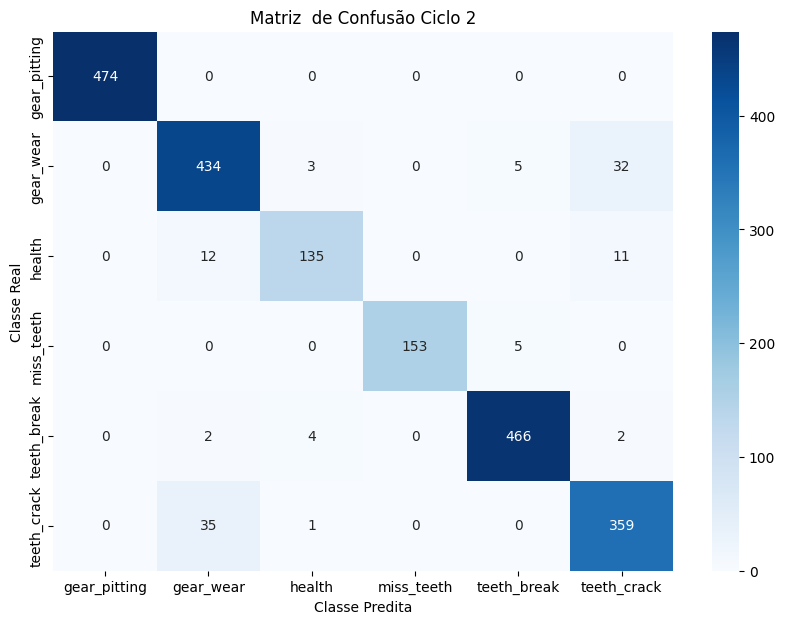

f1-score = 0.9446016253282171


In [26]:
# executar algoritmo com melhor número
start_time_c2_svm = time.time()

rfe = RFE(estimator=estimator, n_features_to_select=30)
rfe = rfe.fit(X_train_c2, y_train_c2)

# Transformar os conjuntos de treino e teste para selecionar as principais features
X_train_c2_rfe = rfe.transform(X_train_c2)
X_test_c2_rfe = rfe.transform(X_test_c2)

# Inicializar e treinar o modelo SVM
svm_model = SVC()
svm_model.fit(X_train_c2_rfe, y_train_c2)    
# Fazer previsões no conjunto de teste
y_pred_svm_test_c2 = svm_model.predict(X_test_c2_rfe)


end_time_c2_svm = time.time()
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_c2, y_pred_svm_test_c2)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz  de Confusão Ciclo 2')
plt.show()

f1_svm_test_c2 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')

print(f'f1-score = {f1_svm_test_c2}')

Resultados Ciclo 2

In [18]:
# Resultados Ciclo 2
accuracy_svm_test_c2 = accuracy_score(y_test_c2, y_pred_svm_test_c2)
recall_svm_test_c2 = recall_score(y_test_c2, y_pred_svm_test_c2, average='macro')
f1_svm_test_c2 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')

print(f'accuracy = {accuracy_svm_test_c2}')
print(f'recall = {recall_svm_test_c2}')
print(f'f1-score = {f1_svm_test_c2}')

accuracy = 0.9231129864041256
recall = 0.9096343178621659
f1-score = 0.9163781710189878


## Ciclo 1

levantamento melhor feature (1)

n= 1 score: 0.4807692307692307
n= 2 score: 0.4807692307692307
n= 3 score: 0.4807692307692307
n= 4 score: 0.4807692307692307
n= 5 score: 0.4807692307692307
n= 6 score: 0.4807692307692307
n= 7 score: 0.4807692307692307
n= 8 score: 0.4807692307692307
n= 9 score: 0.4807692307692307
n= 10 score: 0.4807692307692307
n= 11 score: 0.4807692307692307
n= 12 score: 0.4807692307692307
n= 13 score: 0.4807692307692307
n= 14 score: 0.5357170508945515
n= 15 score: 0.6154626470493267
n= 16 score: 0.7077688960449279
n= 17 score: 0.7037961916270368
n= 18 score: 0.695735366453517
n= 19 score: 0.7037961916270368
n= 20 score: 0.7077688960449279
n= 21 score: 0.6392675147127651
n= 22 score: 0.7441761769888644
n= 23 score: 0.8350815700626273
n= 24 score: 0.8293516670424426
n= 25 score: 0.8322280178837556
n= 26 score: 0.8322280178837556
n= 27 score: 0.8322280178837556
n= 28 score: 0.8262859204659673
n= 29 score: 0.843508245632627
n= 30 score: 0.8407214074626453
n= 31 score: 0.843508245632627
n= 32 score: 0.84627

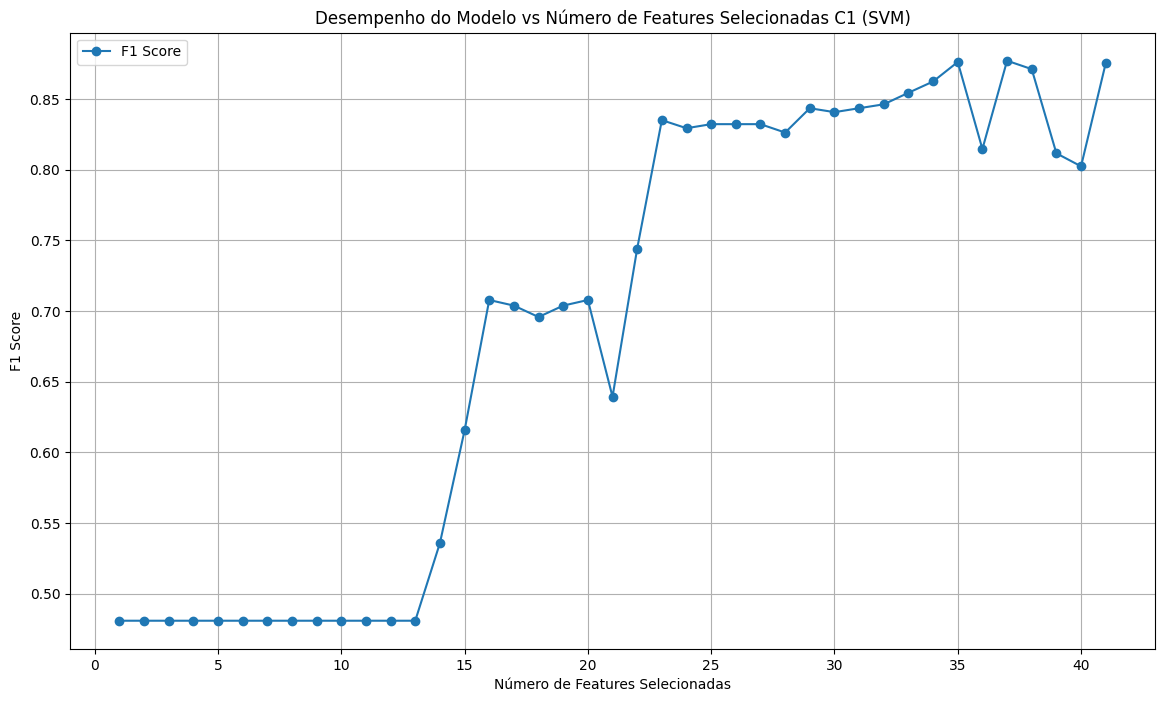

In [19]:
estimator = DecisionTreeClassifier()
#Listas para armazenar as métricas
num_features = list(range(1, X_train_c1.shape[1] + 1))
f1_scores = []
# Loop através de diferentes números de features
start_time_c1_ft = time.time()
for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train_c1, y_train_c1)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c1_rfe = rfe.transform(X_train_c1)
    X_test_c1_rfe = rfe.transform(X_test_c1)
    
    # Inicializar e treinar o modelo svm
    svm_model = SVC()
    svm_model.fit(X_train_c1_rfe, y_train_c1)    
    # Fazer previsões no conjunto de teste
    y_pred_svm_test_c1 = svm_model.predict(X_test_c1_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c1, y_pred_svm_test_c1, average='macro')
    
    # Armazenar a métrica
    f1_scores.append(f1)
    print(f'n= {n} score: {f1}')
end_time_c1_ft = time.time()    

# Plotar o F1 score em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1 Score')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas C1 (SVM)')
plt.legend()
plt.grid(True)
plt.show()

Aplicação melhor feature
e plotar matriz de confusão

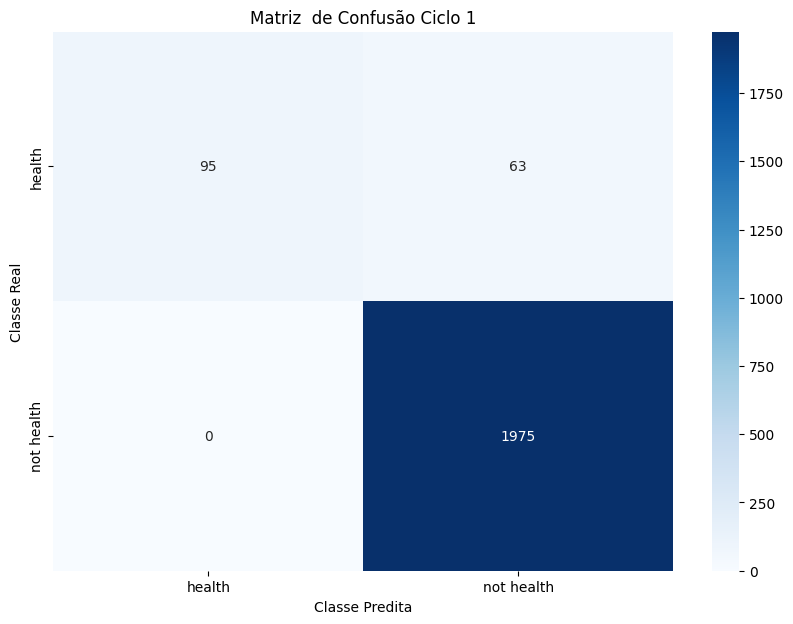

f1-sciore = 0.8676445819860157


In [20]:
start_time_c1_svm = time.time()
# executar algoritmo com melhor número
rfe = RFE(estimator=estimator, n_features_to_select=35)
rfe = rfe.fit(X_train_c1, y_train_c1)

# Transformar os conjuntos de treino e teste para selecionar as principais features
X_train_c1_rfe = rfe.transform(X_train_c1)
X_test_c1_rfe = rfe.transform(X_test_c1)

# Inicializar e treinar o modelo svm
svm_model = SVC()
svm_model.fit(X_train_c1_rfe, y_train_c1)    
# Fazer previsões no conjunto de teste
y_pred_svm_test_c1 = svm_model.predict(X_test_c1_rfe)

end_time_c1_svm = time.time()
# Plot confusion matrix
labels_c1 = ['health','not health']

conf_matrix = confusion_matrix(y_test_c1, y_pred_svm_test_c1)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_c1, yticklabels=labels_c1)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz  de Confusão Ciclo 1')
plt.show()

f1_svm_test_c1 = f1_score(y_test_c1, y_pred_svm_test_c1, average='macro')
print(f'f1-sciore = {f1_svm_test_c1}')

### Resultados SVM

In [28]:
# Resultados Ciclo 1
accuracy_svm_test_c1 = accuracy_score(y_test_c1, y_pred_svm_test_c1)
recall_svm_test_c1 = recall_score(y_test_c1, y_pred_svm_test_c1, average='macro')
f1_svm_test_c1 = f1_score(y_test_c1, y_pred_svm_test_c1, average='macro')




# Create metrics table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'Features'],
    'Score Ciclo 1': [accuracy_svm_test_c1, recall_svm_test_c1, f1_svm_test_c1,'36'],
    'Score Ciclo 2': [accuracy_svm_test_c2, recall_svm_test_c2, f1_svm_test_c2,'24']
})

print(metrics_table)

     Metric Score Ciclo 1 Score Ciclo 2
0  Accuracy      0.970464      0.923113
1    Recall      0.800633      0.909634
2  F1 Score      0.867645      0.944602
3  Features            36            24


Tempos de execução


In [22]:
execution_time_c1_ft = end_time_c1_ft - start_time_c1_ft
execution_time_c2_ft = end_time_c2_ft - start_time_c2_ft
execution_time_c1_svm = end_time_c1_svm - start_time_c1_svm
execution_time_c2_svm = end_time_c2_svm - start_time_c2_svm

print('c1 ft')
print(execution_time_c1_ft)
print('c2 ft')
print(execution_time_c2_ft)
print('c1 svm')
print(execution_time_c1_svm)
print('c2 ft')
print(execution_time_c2_svm)


c1 ft
20.688812494277954
c2 ft
41.2684805393219
c1 svm
0.30652642250061035
c2 ft
0.9738938808441162
